In [1]:
%%capture
%pip install -U bitsandbytes
# %pip install -U transformers
# %pip install -U accelerate
%pip install -U peft
%pip install -U trl

In [2]:
from peft import LoraConfig, prepare_model_for_kbit_training, get_peft_model
import os
from tqdm import tqdm
import bitsandbytes as bnb
import torch
import torch.nn as nn
import transformers
from datasets import Dataset
from peft import LoraConfig, PeftConfig
from trl import SFTTrainer
from trl import setup_chat_format
from google.colab import userdata
from transformers import (AutoModelForCausalLM,
                          AutoTokenizer,
                          BitsAndBytesConfig,
                          TrainingArguments,
                          pipeline,
                          logging)

# Datasets
from datasets import Dataset, DatasetDict
from transformers import AutoModel, AutoTokenizer
from transformers import AutoModelForSequenceClassification, Trainer, TrainingArguments

# Functions
from sklearn.metrics import (accuracy_score, precision_score, recall_score,
                             f1_score, confusion_matrix, classification_report)

#python
import pandas as pd
import numpy as np
import torch

# plots
import matplotlib.pyplot as plt
import seaborn as sns
sns.set_theme()

# Configs and Parameters
color_palette = {
    'Hardware': '#FF5733',        # A vibrant red-orange
    'Access': '#33FF57',          # A bright green
    'Miscellaneous': '#5733FF',   # A deep blue
    'HR Support': '#FF33A8',      # A bright pink
    'Purchase': '#33A8FF',        # A light blue
    'Administrative rights': '#FFA833', # A warm orange
    'Storage': '#A833FF',         # A vivid purple
    'Internal Project': '#33FFA8' # A mint green
}

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

In [3]:
import gc
gc.collect()
torch.cuda.empty_cache()

In [4]:
def compute_metrics_plot(y_true, y_pred, classes, ax):
    class_report = classification_report(y_true, y_pred)

    ax.set_title("Metrics")
    ax.axis('off')  # Turn off the axes

    ax.text(0.2, 0.5, class_report, fontsize=12, ha='center', va='center', transform=ax.transAxes)


def plot_confusion_matrix(y_true, y_pred, classes, ax, normalize=False, title='Confusion Matrix', cmap='Blues' ):

    cm = confusion_matrix(y_true, y_pred)

    if normalize:
        cm = cm.astype('float') / cm.sum(axis=1)[:, np.newaxis]

    cm_df = pd.DataFrame(cm, index=classes, columns=classes)


    sns.heatmap(cm_df, annot=True, fmt='.2f' if normalize else 'd', cmap=cmap, linewidths=.5, square=True, cbar_kws={"shrink": .75}, ax = ax)

    ax.set_title(title, size=15)
    ax.set_ylabel('Actual', size=12)
    ax.set_xlabel('Predicted', size=12)

In [5]:

secret_value_0 = userdata.get('HF_TOKEN')


In [6]:
class CFG:
    SPLIT_VALID_SIZE = 0.2
    TEST_MODE_SIZE = 0.2

    MODEL = "meta-llama/Llama-3.1-8B-Instruct"
    LORA_R = 16
    LORA_ALPHA = 16
    LORA_DROPOUT = 0.05
    LORA_BIAS = 'none'


In [7]:
# Loading Dataset
data = pd.read_csv('/content/all_tickets_processed_improved_v3.csv')

In [8]:


if CFG.TEST_MODE_SIZE:
    data = data.sample(int(CFG.TEST_MODE_SIZE *(data.shape[0])))

data.rename(columns = {'Document':'text', 'Topic_group':'label_str'}, inplace = True)

mapping_labels = {'Hardware': 0,
                 'Access': 1,
                 'Miscellaneous': 2,
                 'HR Support': 3,
                 'Purchase': 4,
                 'Administrative rights': 5,
                 'Storage': 6,
                 'Internal Project': 7}


data['target'] = data['label_str'].map(mapping_labels)
labels = mapping_labels.keys()
# Transforming to Dataset class
df = Dataset.from_dict({
    "text": data['text'],
    "labels": data['target'],
    "label_str": data['label_str']})

# Spliting into train/validation sets
df = df.train_test_split(test_size=CFG.SPLIT_VALID_SIZE,shuffle = True )

df  = DatasetDict({
    'train': df['train'],
    'valid': df['test']
})

# Result
df

DatasetDict({
    train: Dataset({
        features: ['text', 'labels', 'label_str'],
        num_rows: 7653
    })
    valid: Dataset({
        features: ['text', 'labels', 'label_str'],
        num_rows: 1914
    })
})

In [9]:
df.set_format(type = 'pandas')
train_df = df['train'][:]

<ipython-input-10-08f28aa8d3a9>:4: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(data = temp,x = 'label_str', y = 'count', palette = color_palette, ax = ax[0,0]);
<ipython-input-10-08f28aa8d3a9>:6: UserWarning: set_ticklabels() should only be used with a fixed number of ticks, i.e. after set_ticks() or using a FixedLocator.
  ax[0,0].set_xticklabels(ax[0,0].get_xticklabels(), rotation=45, ha='right')
<ipython-input-10-08f28aa8d3a9>:8: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(data = temp,x = 'label_str', y = 'pct', palette = color_palette, ax = ax[0,1]);
<ipython-input-10-08f28aa8d3a9>:10: UserWarning: set_ticklabels() should only be used with a fixed number of ticks, i.e. after set_ti

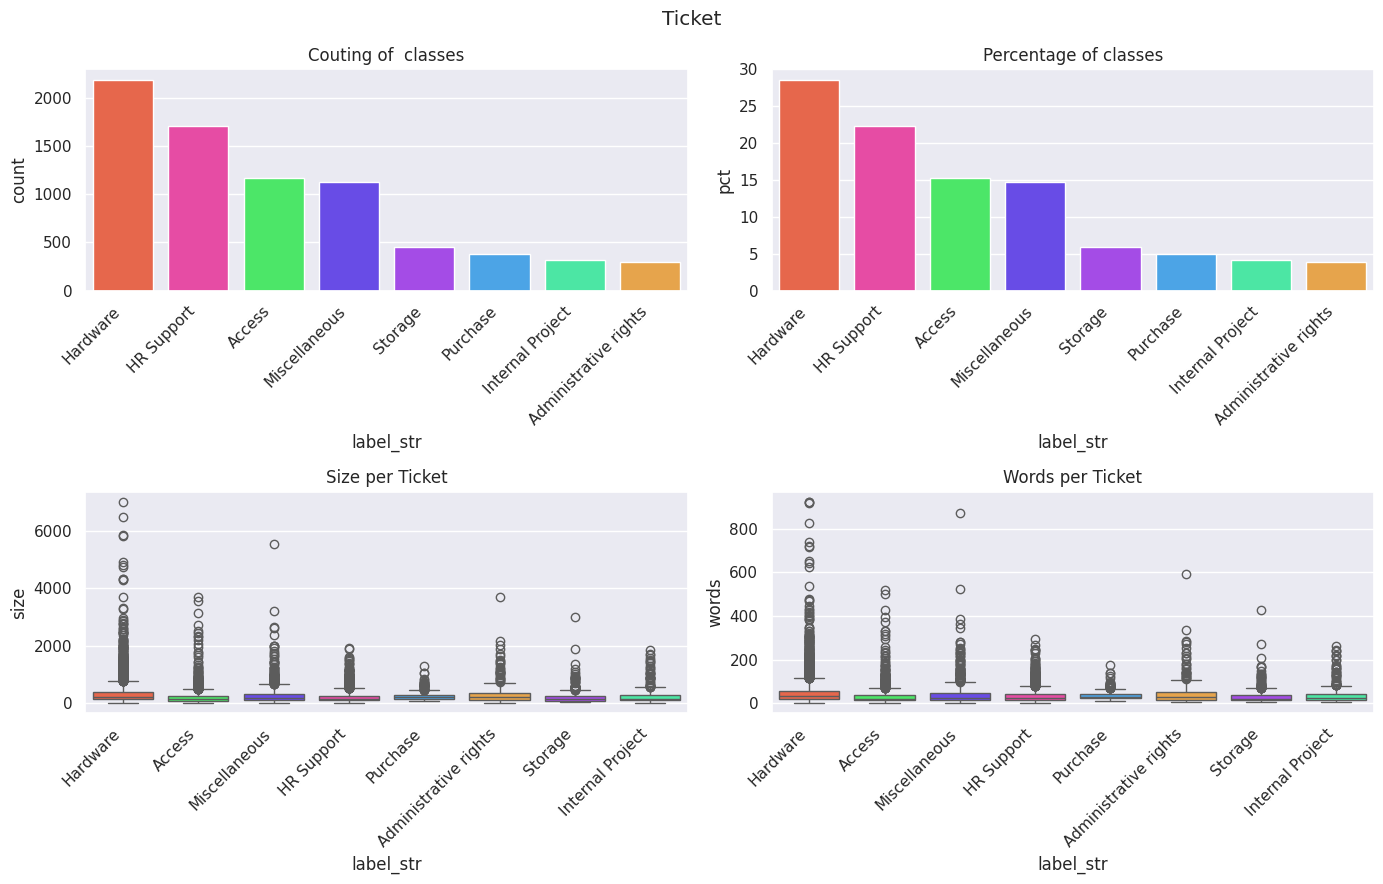

In [10]:
temp = train_df.groupby('label_str').agg(count = ('label_str', 'count')).reset_index().sort_values(by = 'count', ascending = False)
temp['pct'] = temp['count']/(temp['count'].sum()) *100
fig, ax = plt.subplots(figsize = (14, 9), ncols = 2, nrows = 2)
sns.barplot(data = temp,x = 'label_str', y = 'count', palette = color_palette, ax = ax[0,0]);
ax[0, 0].set_title('Couting of  classes');
ax[0,0].set_xticklabels(ax[0,0].get_xticklabels(), rotation=45, ha='right')

sns.barplot(data = temp,x = 'label_str', y = 'pct', palette = color_palette, ax = ax[0,1]);
ax[0,1].set_title('Percentage of classes');
ax[0,1].set_xticklabels(ax[0,1].get_xticklabels(), rotation=45, ha='right')

plt.suptitle('Ticket');


train_df['size'] = (train_df['text'].apply(len))
train_df['words'] = (train_df['text'].str.split(' ')).apply(len)

sns.boxplot(data = train_df, x = 'label_str', y = 'size', palette = color_palette, order = color_palette.keys(), ax = ax[1,0])
ax[1,0].set_title('Size per Ticket');
ax[1,0].set_xticklabels(ax[1,0].get_xticklabels(), rotation=45, ha='right')


sns.boxplot(data = train_df, x = 'label_str', y = 'words', palette = color_palette, order = color_palette.keys(), ax = ax[1,1])
ax[1,1].set_title('Words per Ticket');
ax[1,1].set_xticklabels(ax[1,1].get_xticklabels(), rotation=45, ha='right')

plt.tight_layout()

In [11]:
train_df.query('words > 500').iloc[0]['text']

'request supporting a rd party pen test for a client to take place from inside the network supporting rd party pen test client take inside has assigned hi guys please log information assign queue discussed thanks coordinator december re supporting rd party pen test client take inside has assigned hi stand discussing next tuesday please expect update then thank december re supporting rd party pen test client take inside has assigned hi sound well teams cannot commit date right chased by third party update date want suggest ready because sounds find response suggesting february instead kind regards december re supporting rd party pen test client take inside has assigned hi unfortunately even holiday period allow done december spoken done even cannot book control tickets flow allow he advised his done by then back thank november re supporting rd party pen test client take inside has assigned thanks let client soonest ready which had kind regards november re supporting rd party pen test cl

In [12]:
df.reset_format()

In [13]:
# bits and byts config,
bnb_config = BitsAndBytesConfig(
    load_in_4bit=True,
    bnb_4bit_use_double_quant=False,
    bnb_4bit_quant_type="nf4",
    bnb_4bit_compute_dtype="float16",
)

In [14]:
# Load model from pretrained
model =  AutoModelForSequenceClassification.from_pretrained(
    CFG.MODEL,
    device_map="auto",
    torch_dtype="float16",
    quantization_config=bnb_config,
    token = secret_value_0,
    num_labels = len(labels)
)


# Load Tokenizer
tokenizer = AutoTokenizer.from_pretrained(CFG.MODEL,token = secret_value_0)
tokenizer.pad_token_id = tokenizer.eos_token_id
tokenizer.pad_token = tokenizer.eos_token


model.config.pad_token_id = tokenizer.pad_token_id
model.config.use_cache = False
model.config.pretraining_tp = 1

config.json:   0%|          | 0.00/855 [00:00<?, ?B/s]

model.safetensors.index.json:   0%|          | 0.00/23.9k [00:00<?, ?B/s]

model-00001-of-00004.safetensors:   0%|          | 0.00/4.98G [00:00<?, ?B/s]

model-00002-of-00004.safetensors:   0%|          | 0.00/5.00G [00:00<?, ?B/s]

model-00003-of-00004.safetensors:   0%|          | 0.00/4.92G [00:00<?, ?B/s]

model-00004-of-00004.safetensors:   0%|          | 0.00/1.17G [00:00<?, ?B/s]

Loading checkpoint shards:   0%|          | 0/4 [00:00<?, ?it/s]

Some weights of LlamaForSequenceClassification were not initialized from the model checkpoint at meta-llama/Llama-3.1-8B-Instruct and are newly initialized: ['score.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


tokenizer_config.json:   0%|          | 0.00/55.4k [00:00<?, ?B/s]

tokenizer.json:   0%|          | 0.00/9.09M [00:00<?, ?B/s]

special_tokens_map.json:   0%|          | 0.00/296 [00:00<?, ?B/s]

In [15]:
def predict_test(sentences,model, tokenizer, batch_size):

    all_outputs = []

    for i in range(0, len(sentences), batch_size):
        # Get the batch of sentences
        batch_sentences = sentences[i:i + batch_size]

        inputs = tokenizer(batch_sentences,
                           return_tensors="pt",
                           padding=True,
                           truncation=True,
                           max_length=512)

        inputs = {k: v.to(device) for k, v in inputs.items()}

        # Perform inference and store the logits
        with torch.no_grad():
            outputs = model(**inputs)
            all_outputs.append(outputs['logits'])

    return  torch.cat(all_outputs, dim=0).argmax(axis=1).cpu().numpy()

In [16]:
y_true = df['valid']['labels']
batch_size = 32
outputs = predict_test(sentences = df['valid']['text'],
                       model = model,
                       tokenizer = tokenizer,
                       batch_size = 4)

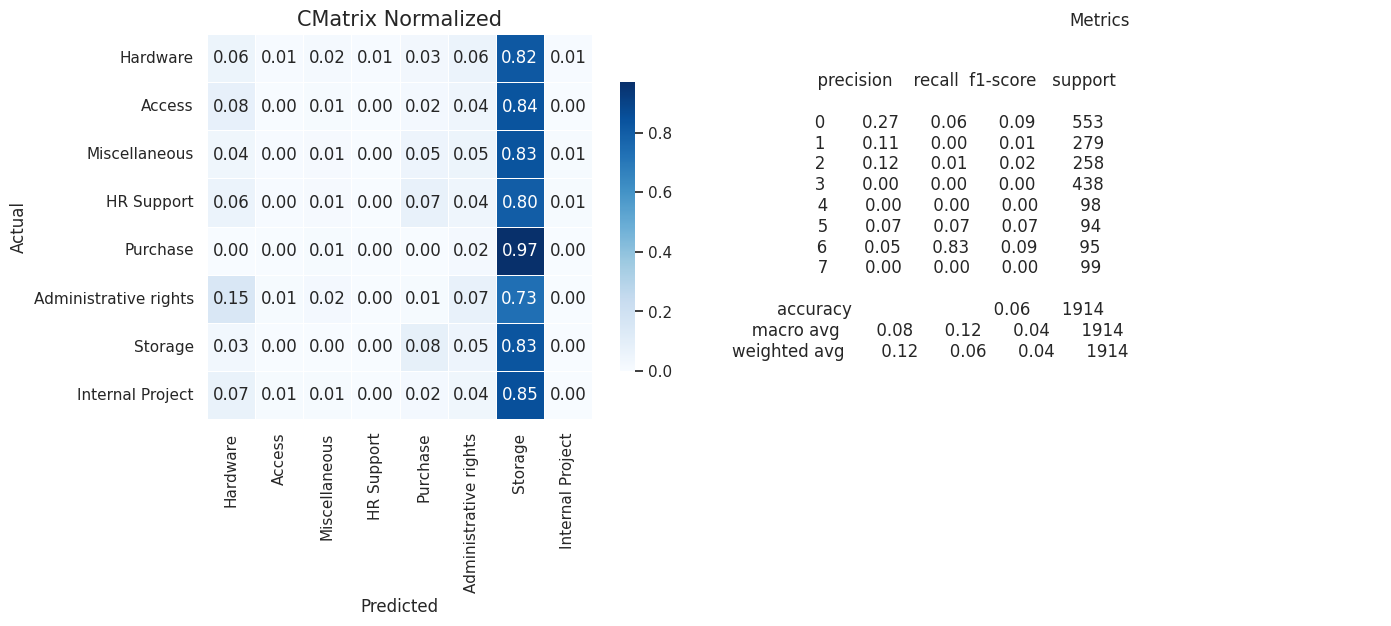

In [17]:
fig, ax = plt.subplots(figsize = (16, 5), ncols = 2)
plot_confusion_matrix(y_true, outputs, classes=labels, normalize=True, title='CMatrix Normalized', ax = ax[0])
compute_metrics_plot(y_true, outputs, labels, ax[1])

In [18]:
def compute_metrics(pred):
    labels = pred.label_ids
    preds = pred.predictions.argmax(-1)
    f1 = f1_score(labels, preds, average="weighted")
    acc = accuracy_score(labels, preds)
    return {"accuracy": acc, "f1": f1}


In [19]:
def preprocessor_tokenizer(examples):
    return tokenizer(examples['text'], truncation=True, max_length=512)

tokenized_datasets = df.map(preprocessor_tokenizer, batched=True)
tokenized_datasets.set_format("torch")


Map:   0%|          | 0/7653 [00:00<?, ? examples/s]

Map:   0%|          | 0/1914 [00:00<?, ? examples/s]

In [20]:
lora_config = LoraConfig(
    r = CFG.LORA_R,
    lora_alpha = CFG.LORA_ALPHA,
    target_modules = ['q_proj', 'k_proj', 'v_proj','o_proj'],
    lora_dropout = CFG.LORA_DROPOUT,
    bias = CFG.LORA_BIAS,
    task_type = 'SEQ_CLS'
)

In [21]:
bnb_config = BitsAndBytesConfig(
    load_in_4bit = True, # enable 4-bit quantization
    bnb_4bit_quant_type = 'nf4', # information theoretically optimal dtype for normally distributed weights
    bnb_4bit_use_double_quant = True, # quantize quantized weights //insert xzibit meme
    bnb_4bit_compute_dtype = torch.bfloat16 # optimized fp format for ML
)
model = prepare_model_for_kbit_training(model)
model = get_peft_model(model, lora_config)

In [22]:
model.print_trainable_parameters()

trainable params: 13,664,256 || all params: 7,518,621,696 || trainable%: 0.1817


In [23]:
training_args = TrainingArguments(
    output_dir = 'finetuning_llama3',
    learning_rate = 1e-4,
    per_device_train_batch_size = 8,
    per_device_eval_batch_size = 8,
    num_train_epochs = 1,
    weight_decay = 0.01,
    evaluation_strategy = 'epoch',
    save_strategy = 'epoch',
    load_best_model_at_end = True,
    push_to_hub=False,
    report_to = 'none'
)

/usr/local/lib/python3.11/dist-packages/transformers/training_args.py:1575: FutureWarning: `evaluation_strategy` is deprecated and will be removed in version 4.46 of 🤗 Transformers. Use `eval_strategy` instead
  warnings.warn(


In [24]:
trainer = Trainer(
    model = model,
    args = training_args,
    train_dataset = tokenized_datasets['train'],
    eval_dataset = tokenized_datasets['valid'],
    tokenizer = tokenizer,
    compute_metrics = compute_metrics,
)

<ipython-input-24-a7a6db4dd911>:1: FutureWarning: `tokenizer` is deprecated and will be removed in version 5.0.0 for `Trainer.__init__`. Use `processing_class` instead.
  trainer = Trainer(


In [25]:
out_trainer = trainer.train()
out_trainer.metrics

/usr/local/lib/python3.11/dist-packages/torch/_dynamo/eval_frame.py:632: UserWarning: torch.utils.checkpoint: the use_reentrant parameter should be passed explicitly. In version 2.5 we will raise an exception if use_reentrant is not passed. use_reentrant=False is recommended, but if you need to preserve the current default behavior, you can pass use_reentrant=True. Refer to docs for more details on the differences between the two variants.
  return fn(*args, **kwargs)


Epoch,Training Loss,Validation Loss,Accuracy,F1
1,1.094800,0.523357,0.831243,0.830686


{'train_runtime': 3937.8446,
 'train_samples_per_second': 1.943,
 'train_steps_per_second': 0.243,
 'total_flos': 4.336523514998784e+16,
 'train_loss': 0.8471735811781609,
 'epoch': 1.0}

In [26]:
preds_output = trainer.predict(tokenized_datasets["valid"])
y_pred_valid = np.argmax(preds_output.predictions, axis = 1)

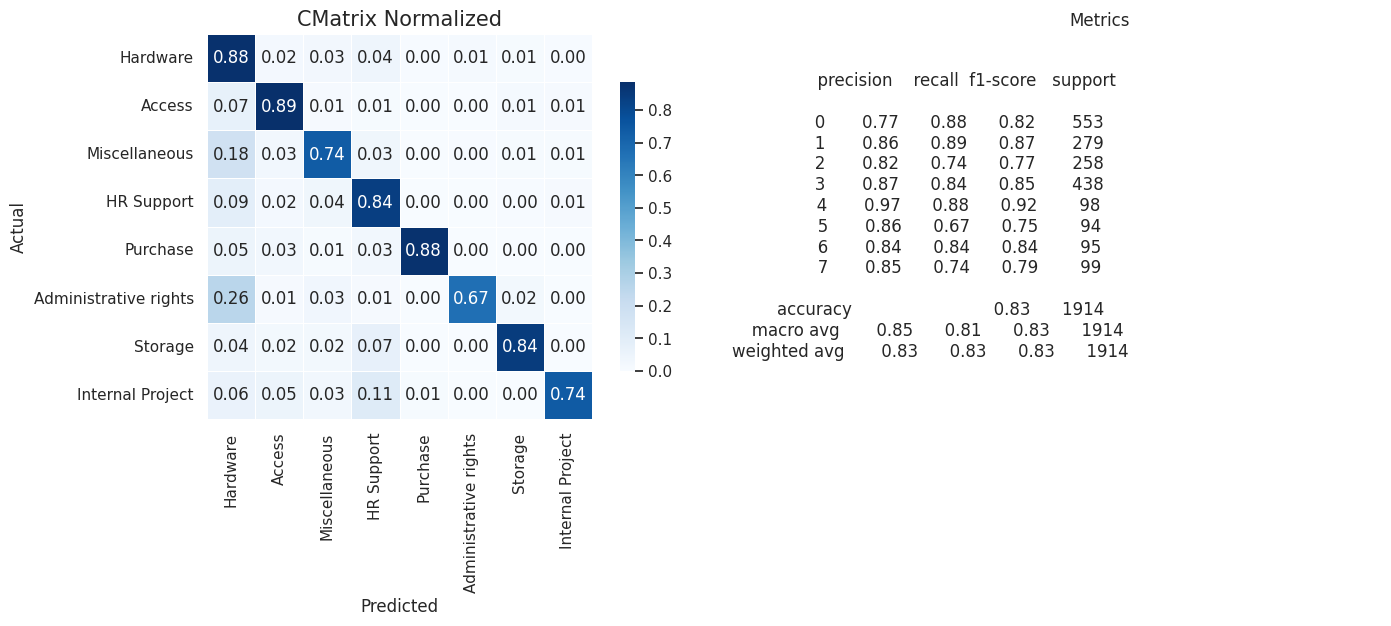

In [27]:
fig, ax = plt.subplots(figsize = (16, 5), ncols = 2)
plot_confusion_matrix(y_true, y_pred_valid, classes=labels, normalize=True, title='CMatrix Normalized', ax = ax[0])
compute_metrics_plot(y_true, y_pred_valid, labels, ax[1])

In [28]:
!zip -r fintune.zip /content/finetuning_llama3

  adding: content/finetuning_llama3/ (stored 0%)
  adding: content/finetuning_llama3/checkpoint-957/ (stored 0%)
  adding: content/finetuning_llama3/checkpoint-957/training_args.bin (deflated 51%)
  adding: content/finetuning_llama3/checkpoint-957/tokenizer_config.json (deflated 94%)
  adding: content/finetuning_llama3/checkpoint-957/adapter_model.safetensors (deflated 7%)
  adding: content/finetuning_llama3/checkpoint-957/tokenizer.json (deflated 85%)
  adding: content/finetuning_llama3/checkpoint-957/adapter_config.json (deflated 54%)
  adding: content/finetuning_llama3/checkpoint-957/special_tokens_map.json (deflated 63%)
  adding: content/finetuning_llama3/checkpoint-957/README.md (deflated 66%)
  adding: content/finetuning_llama3/checkpoint-957/rng_state.pth (deflated 25%)
  adding: content/finetuning_llama3/checkpoint-957/scheduler.pt (deflated 57%)
  adding: content/finetuning_llama3/checkpoint-957/trainer_state.json (deflated 55%)
  adding: content/finetuning_llama3/checkpoint-

In [ ]:
from transformers import AutoModelForCausalLM, AutoTokenizer
import torch

# Path to the fine-tuned model
checkpoint_path = "/content/finetuning_llama3/checkpoint-957"  # Update this with your actual path

# Load tokenizer and model
tokenizer = AutoTokenizer.from_pretrained(checkpoint_path)
model = AutoModelForCausalLM.from_pretrained(checkpoint_path, torch_dtype=torch.float16)

# Set to evaluation mode
model.eval()

Loading checkpoint shards:   0%|          | 0/4 [00:00<?, ?it/s]